In [2]:
import requests
import visualisationGlock2 as v
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time


urlo = "https://entersim.bloctave.fr/"
sim_id = "sim2"
url = f'https://entersim.bloctave.fr/control/poll/create_from_example/{sim_id}'
response = requests.post(url)
print(response)

<Response [201]>


In [ ]:
#FUNCTIONS
def initOneStep() :
    requests.post( urlo+ "control/poll/run_one_step")

def getPoll(url) :
    return requests.get(urlo + "enterprise/poll/"+url)

In [ ]:
#FONDS EN EURO
t = 0
graph = v.LineGraph("Funds in euro", x_legend='Hours', y_legend="Funds in euro")
for i in range(100):
    requests.post( urlo+ "control/poll/run_one_step")
    url = urlo + "enterprise/poll/inventory"
    response = requests.get(url, stream=True)   
    t += 1
    x = response.json()["funds_in_eur"]
    graph.addPoint(t,x)

In [ ]:
#ETATS DES MACHINES
t = 0
graph = v.MultipleLineGraph(['Machine1', 'Machine2'], 'Taux nominal machine', x_legend = 'Hours', y_legend='Taux de production')

for i in range(100):
    requests.post( urlo+ "control/poll/run_one_step")
    response = requests.get(urlo + "enterprise/poll/machine")
    X=[]
    for json in response.json() :
        #print(json)
        X.append(json['machine_type']['nominal_output_rate_items_per_hour'])
    print(X)
    graph.addPoint(i,X)

In [ ]:
#INVENTAIRE

#Initialisation
nbStep = 100
t = 0
initOneStep()

#Graph making
response = getPoll('inventory').json()
nameList = [item['item']['name'] for item in response['item_quantities']]
graph = v.MultipleLineGraph(nameList, 'Quantities', x_legend = 'Hours', y_legend='Quantity of items')

for i in range(nbStep):
    X=[]
    for dic in response['item_quantities'] :
        X.append(dic['quantity'])
    print(X)
    graph.addPoint(i,X)

    response = getPoll('inventory').json()

In [ ]:
#SUPER TITRE

for i in range(100):
    requests.post( urlo+ "control/poll/run_one_step")
    response = requests.get(urlo + "enterprise/poll/employee")
    employe =[]
    hours =[]
    for json in response.json() :
        #print(json)
        employe += [(json['name'])]
        hours.append(json['remaining_sickness_in_hours_worked'])
    clear_output(wait=True)
    plt.bar(employe, hours)
    plt.show()

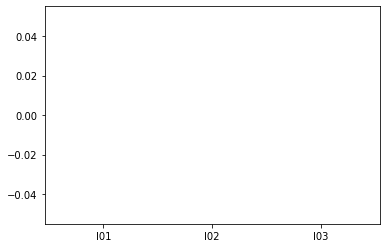

In [3]:
#INVENTORY PER TYPE OF ITEM 

for t in range(100):
    requests.post( urlo+ "control/poll/run_one_step")
    response = requests.get(urlo + "enterprise/poll/inventory")
    names =[]
    quantity =[]

    for json in response.json()["item_quantities"] :
        #print(json)
        names.append((json['item']['name']))
        quantity.append(json['quantity'])
    clear_output(wait=True)
    plt.bar(names, quantity)
    plt.title(f"INVENTORY PER TYPE OF ITEM / T = {time}")
    plt.show()